<a href="https://colab.research.google.com/github/kanikabanjare11/Fraud-Detection-in-Financial-Transactions/blob/main/Financial_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Processing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

# Metrics and Evaluation
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    average_precision_score,
    cohen_kappa_score,
    matthews_corrcoef
)

# Imbalanced Data Handling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import tensorflow as tf

class FraudDetectionMetrics:
    def __init__(self, filepath):
        # Load dataset
        self.data = pd.read_csv(filepath)

        # Separate features and target
        self.X = self.data.drop(['Class'], axis=1)
        self.y = self.data['Class']

    def preprocess_data(self):
        """Preprocess the data"""
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(self.X)

        return X_scaled

    def split_data(self, X_scaled, test_size=0.2, random_state=42):
        """Split data into training and testing sets"""
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, self.y,
            test_size=test_size,
            random_state=random_state,
            stratify=self.y
        )

        return X_train, X_test, y_train, y_test

    def create_model_pipeline(self, classifier):
        """Create a machine learning pipeline with SMOTE"""
        pipeline = Pipeline([
            ('smote', SMOTE(random_state=42)),
            ('classifier', classifier)
        ])

        return pipeline

    def evaluate_model(self, y_true, y_pred, y_pred_proba, model_name):
        """Comprehensive model evaluation"""
        print(f"\n--- {model_name} Model Evaluation ---")

        # Basic Metrics
        metrics = {
            'Accuracy': accuracy_score(y_true, y_pred),
            'Precision': precision_score(y_true, y_pred),
            'Recall': recall_score(y_true, y_pred),
            'F1 Score': f1_score(y_true, y_pred),
            'ROC AUC': roc_auc_score(y_true, y_pred_proba),
            'Average Precision': average_precision_score(y_true, y_pred_proba),
            'Cohen Kappa': cohen_kappa_score(y_true, y_pred),
            'Matthews Correlation': matthews_corrcoef(y_true, y_pred)
        }

        # Print metrics
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'{model_name} ROC Curve')
        plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
        plt.title(f'ROC Curve - {model_name}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

        # Precision-Recall Curve
        precisions, recalls, _ = precision_recall_curve(y_true, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(recalls, precisions, label=f'{model_name} Precision-Recall Curve')
        plt.title(f'Precision-Recall Curve - {model_name}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.show()

        return metrics

    def train_and_evaluate_models(self, X_train, X_test, y_train, y_test):
        """Train and evaluate multiple models"""
        models = {
            # 'Logistic Regression': LogisticRegression(class_weight='balanced'),
            # 'Random Forest': RandomForestClassifier(class_weight='balanced'),
            # 'Gradient Boosting': GradientBoostingClassifier(),
            # 'XGBoost': XGBClassifier(scale_pos_weight=1),
            'SVM': SVC(class_weight='balanced', probability=True)
        }

        results = {}

        for name, model in models.items():
            # Create pipeline with SMOTE
            pipeline = self.create_model_pipeline(model)

            # Fit the pipeline
            pipeline.fit(X_train, y_train)

            # Predictions
            y_pred = pipeline.predict(X_test)
            y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

            # Evaluate model
            results[name] = self.evaluate_model(y_test, y_pred, y_pred_proba, name)

        return results

    def deep_learning_model(self, X_train, X_test, y_train, y_test):
        """Create and evaluate deep learning model"""
        # Prepare data with SMOTE
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        # Neural Network Model
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        # Compile model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        # Class weights
        class_weights = {0: 1., 1: 50.}

        # Train model
        model.fit(
            X_train_resampled, y_train_resampled,
            validation_split=0.2,
            epochs=50,
            batch_size=32,
            class_weight=class_weights,
            verbose=0
        )

        # Predictions
        y_pred_proba = model.predict(X_test).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)

        # Evaluate Deep Learning Model
        return self.evaluate_model(y_test, y_pred, y_pred_proba, 'Deep Learning')



--- Logistic Regression Model Evaluation ---
Accuracy: 0.9741
Precision: 0.0579
Recall: 0.9184
F1 Score: 0.1089
ROC AUC: 0.9710
Average Precision: 0.7245
Cohen Kappa: 0.1060
Matthews Correlation: 0.2270


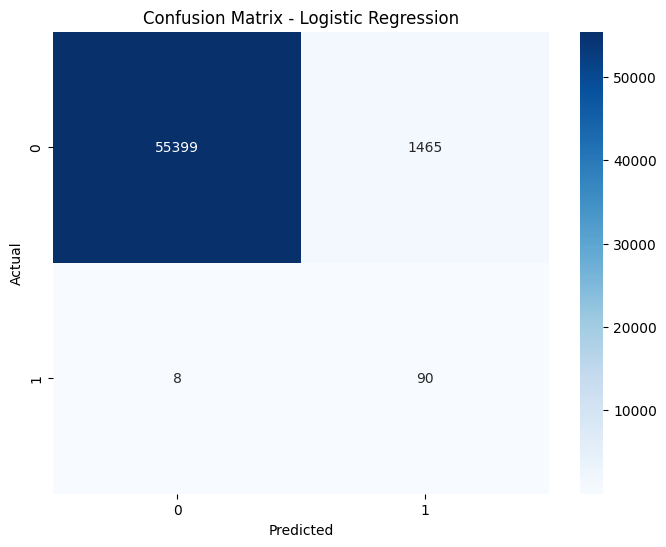

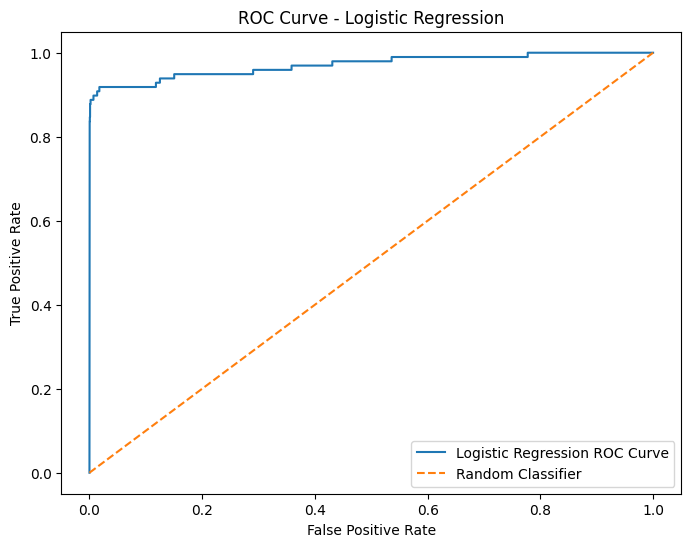

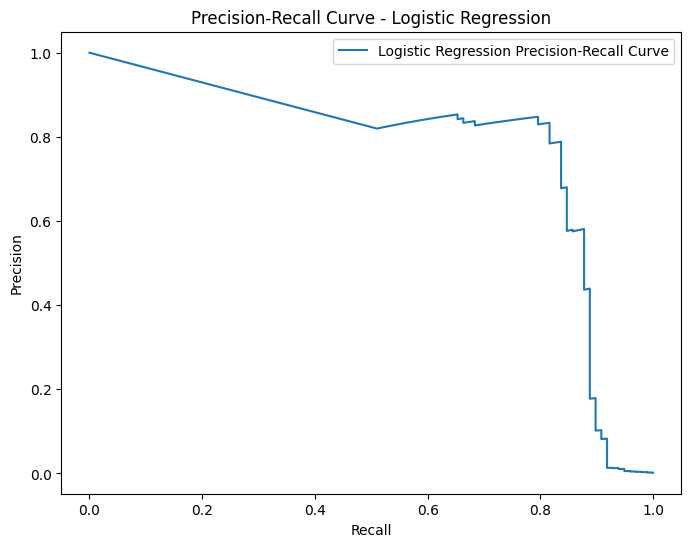


--- Random Forest Model Evaluation ---
Accuracy: 0.9995
Precision: 0.8696
Recall: 0.8163
F1 Score: 0.8421
ROC AUC: 0.9687
Average Precision: 0.8662
Cohen Kappa: 0.8418
Matthews Correlation: 0.8423


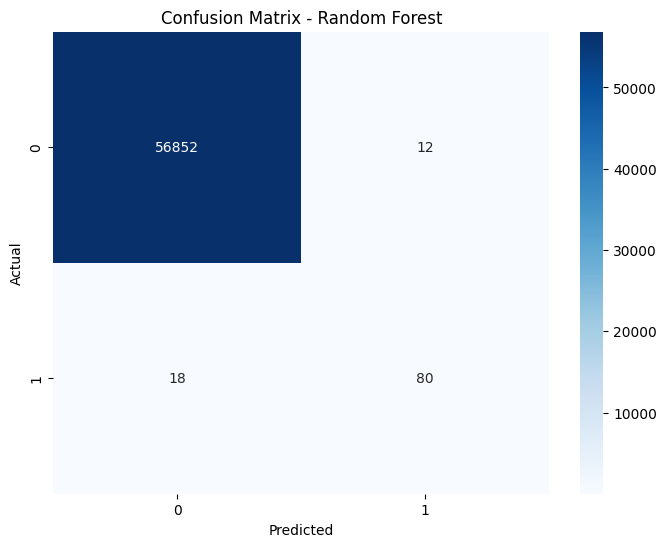

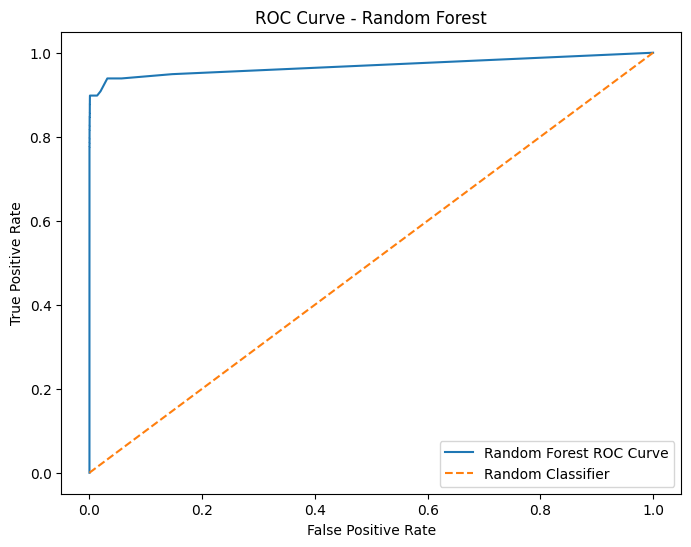

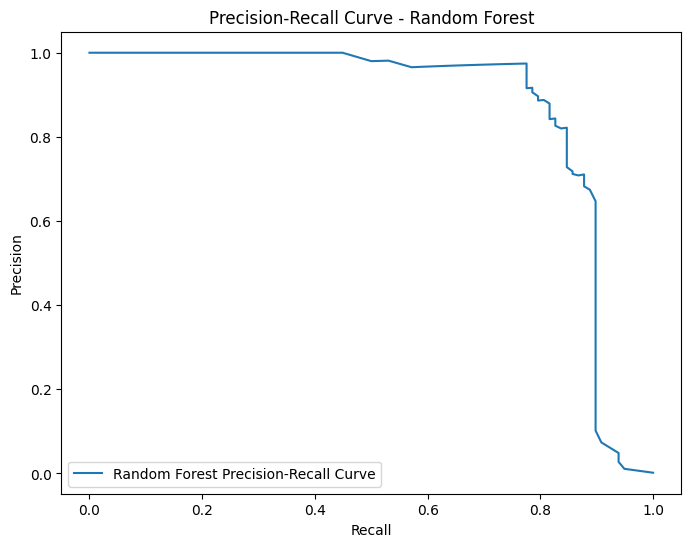


--- Gradient Boosting Model Evaluation ---
Accuracy: 0.9870
Precision: 0.1091
Recall: 0.9184
F1 Score: 0.1950
ROC AUC: 0.9818
Average Precision: 0.7540
Cohen Kappa: 0.1925
Matthews Correlation: 0.3141


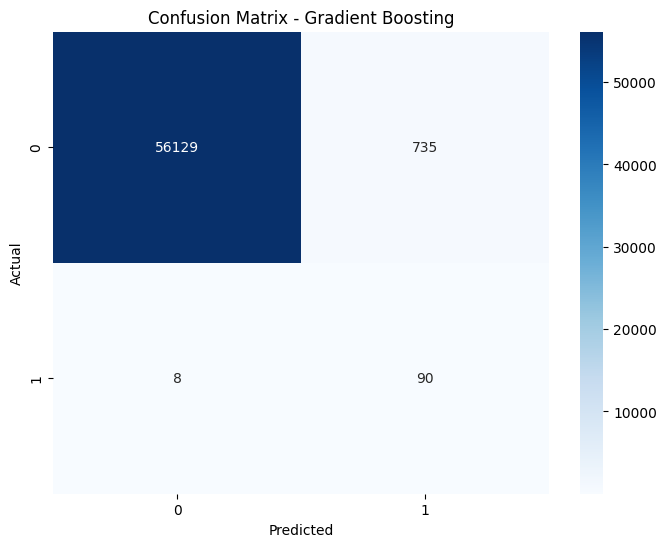

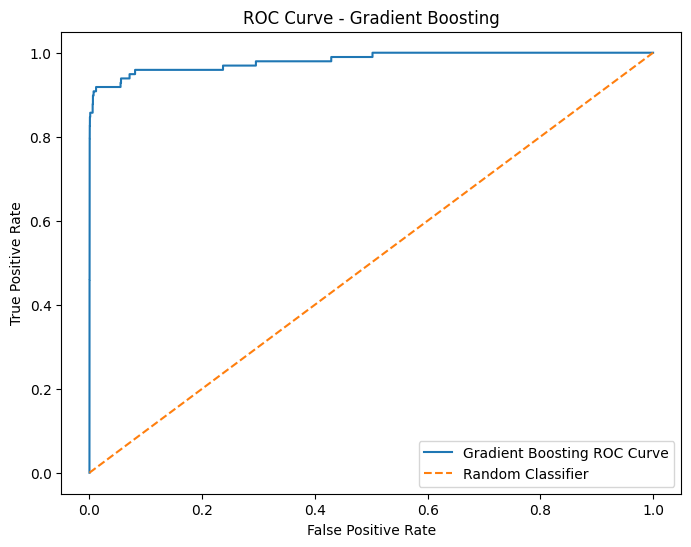

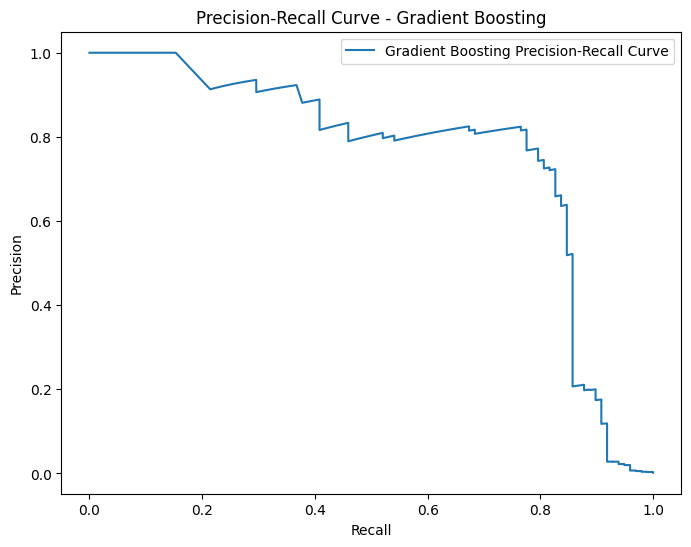


--- XGBoost Model Evaluation ---
Accuracy: 0.9991
Precision: 0.6885
Recall: 0.8571
F1 Score: 0.7636
ROC AUC: 0.9831
Average Precision: 0.8674
Cohen Kappa: 0.7632
Matthews Correlation: 0.7678


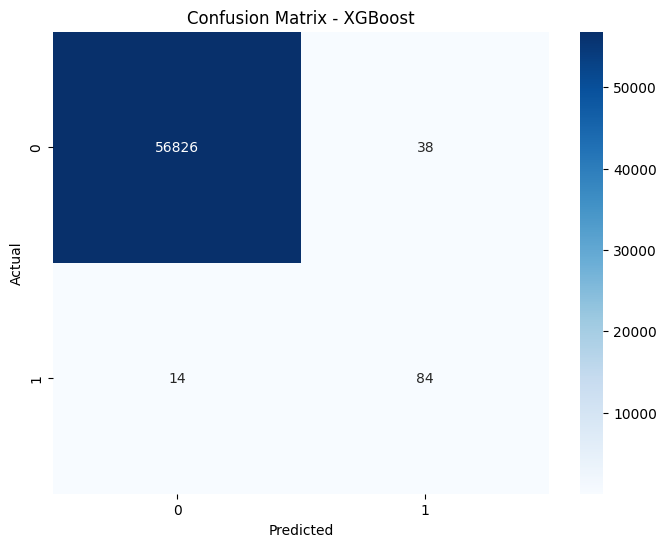

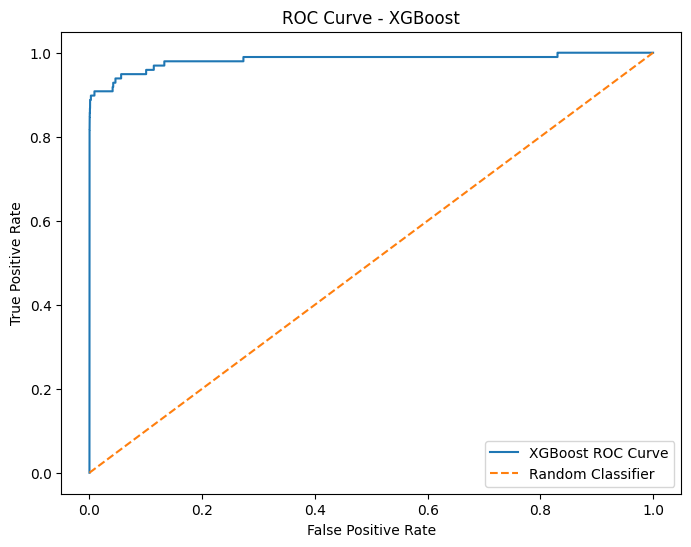

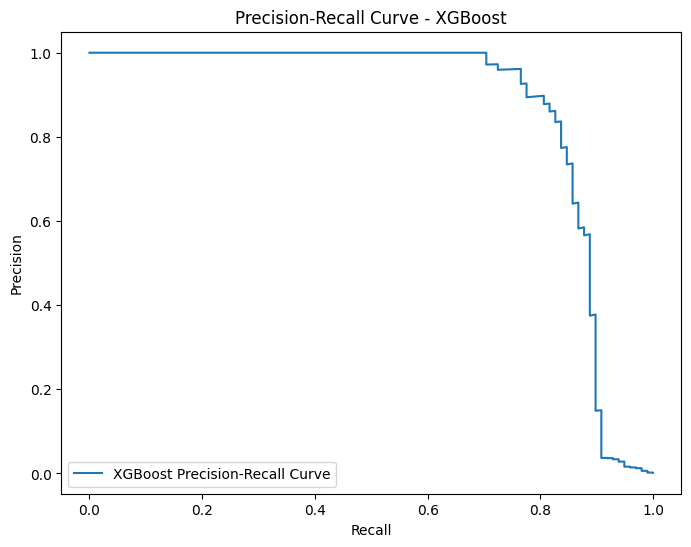

In [ ]:
def main():
    # File path to your dataset
    filepath = 'creditcard.csv'

    # Initialize metrics calculator
    metrics_calculator = FraudDetectionMetrics(filepath)

    # Preprocess data
    X_scaled = metrics_calculator.preprocess_data()

    # Split data
    X_train, X_test, y_train, y_test = metrics_calculator.split_data(X_scaled)

    # Train and evaluate traditional ML models
    ml_results = metrics_calculator.train_and_evaluate_models(X_train, X_test, y_train, y_test)

    # Train and evaluate deep learning model
    dl_results = metrics_calculator.deep_learning_model(X_train, X_test, y_train, y_test)

if __name__ == "__main__":
    main()

In [ ]:
def main():
    # File path to your dataset
    filepath = 'creditcard.csv'

    # Initialize metrics calculator
    metrics_calculator = FraudDetectionMetrics(filepath)

    # Preprocess data
    X_scaled = metrics_calculator.preprocess_data()

    # Split data
    X_train, X_test, y_train, y_test = metrics_calculator.split_data(X_scaled)

    # Train and evaluate traditional ML models
    ml_results = metrics_calculator.train_and_evaluate_models(X_train, X_test, y_train, y_test)

    # Train and evaluate deep learning model
    dl_results = metrics_calculator.deep_learning_model(X_train, X_test, y_train, y_test)

if __name__ == "__main__":
    main()


--- XGBoost Model Evaluation ---
Accuracy: 0.9991
Precision: 0.6885
Recall: 0.8571
F1 Score: 0.7636
ROC AUC: 0.9831
Average Precision: 0.8674
Cohen Kappa: 0.7632
Matthews Correlation: 0.7678



--- Gradient Boosting Model Evaluation ---
Accuracy: 0.9870
Precision: 0.1091
Recall: 0.9184
F1 Score: 0.1950
ROC AUC: 0.9818
Average Precision: 0.7540
Cohen Kappa: 0.1925
Matthews Correlation: 0.3141



--- Random Forest Model Evaluation ---
Accuracy: 0.9995
Precision: 0.8696
Recall: 0.8163
F1 Score: 0.8421
ROC AUC: 0.9687
Average Precision: 0.8662
Cohen Kappa: 0.8418
Matthews Correlation: 0.8423



--- Logistic Regression Model Evaluation ---
Accuracy: 0.9741
Precision: 0.0579
Recall: 0.9184
F1 Score: 0.1089
ROC AUC: 0.9710
Average Precision: 0.7245
Cohen Kappa: 0.1060
Matthews Correlation: 0.2270